In [264]:
import numpy as np
import pandas as pd

import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold

from scipy import stats
from sklearn import preprocessing 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from statsmodels.tsa.stattools import adfuller

import statsmodels
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
from pandas import Timestamp

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

import xgboost as xgb
from xgboost import XGBRegressor 
from xgboost.sklearn import XGBClassifier # sklearn’s Grid Search with parallel processing
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from catboost import CatBoostRegressor
from pmdarima.arima import auto_arima
pd.set_option('display.max_rows',None)

import itertools

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('DF_File_sample.csv')
data['SKU_Customer'] = data['DemandCustomer'] + '_' + data['SKU10']
data_labels = data['SKU_Customer'] 
data.drop(['DemandCustomer', 'SKU10'], axis =1, inplace = True)

In [3]:
data['year_week'] = data['Year'].astype(str) + '-' + data['Week_No'].astype(str)
data['date'] = data['year_week'].apply(lambda x: datetime.datetime.strptime(x + '-4',  "%G-%V-%w"))

In [4]:
first_null = data.groupby('date').Sales.sum().loc[lambda x: x == 0].sort_values().index[0]
data = data[data.date < first_null]

first_26_week = pd.Series(sorted(data['date'].unique())).iloc[-26]
# first_34_week = pd.Series(sorted(data['date'].unique())).iloc[-34]

data.set_index('date', inplace = True)
data = data.iloc[np.lexsort((data.SKU_Customer.values, data.index)), [5, 7]]

### new dataset for one SKU:

In [6]:
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

### Example with not_stationary data: 

In [7]:
data_pred = data[data['SKU_Customer']=='DRUGSTORE_51700-77050'].Sales

In [8]:
SKU_Customer_list = data.SKU_Customer.unique()

In [9]:
Not_stationary = [i for i in SKU_Customer_list if adfuller(data[data['SKU_Customer']==i].Sales, autolag='AIC', maxlag = 20 )[1]>0.05]

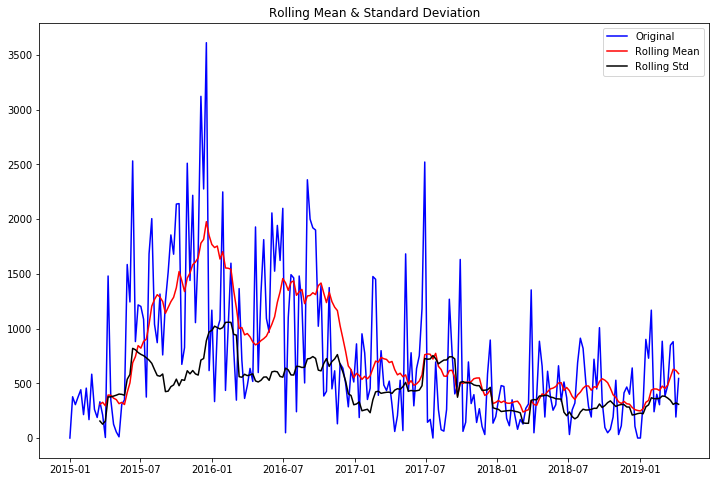

Results of Dickey-Fuller Test:
p-value = 0.1014. The series is likely non-stationary.
Test Statistic                  -2.560543
p-value                          0.101429
#Lags Used                       6.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


In [14]:
test_stationarity(data[data['SKU_Customer']=='DRUGSTORE_51700-77050'].Sales)

In [10]:
import statsmodels.tsa.api as smt

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

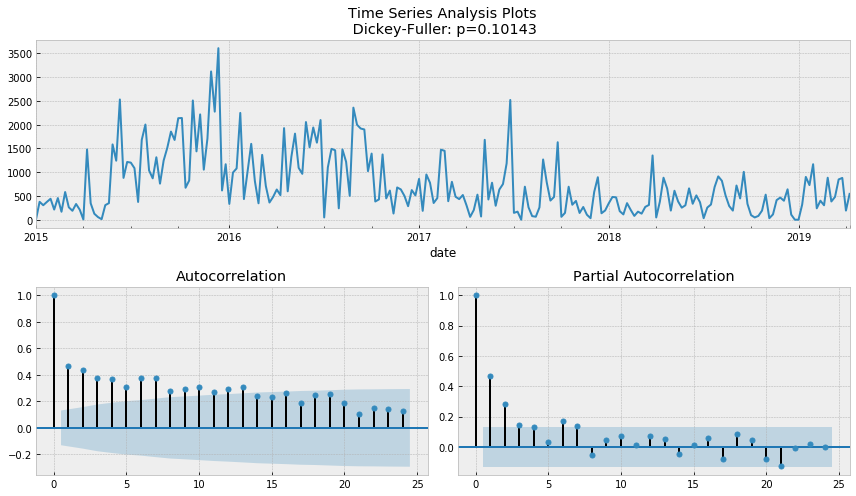

In [17]:
tsplot(data[data['SKU_Customer']=='DRUGSTORE_51700-77050'].Sales)

count     224.000000
mean      909.758929
std       779.836303
min         0.000000
25%       460.000000
50%       755.000000
75%      1088.000000
max      5474.000000
Name: Sales, dtype: float64

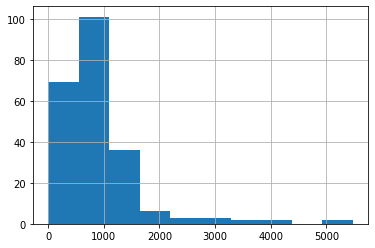

In [81]:
itog = data_pred.describe()
data_pred.hist()
itog

In [84]:
print('V = %f' % (itog['std']/itog['mean']))

V = 0.857190


In [11]:
train = data_pred[data_pred.index < first_26_week]
test = data_pred[data_pred.index >= first_26_week]

In [12]:
perc = 25
lenth = int(len(train)*(perc/100))
valid = train.tail(lenth)
Train = train.tail(-lenth)

Text(0.5, 1.0, 'Dataset distribution')

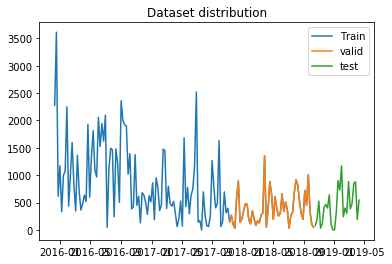

In [58]:
plt.plot(Train, label='Train')
plt.plot(valid, label='valid')
plt.plot(test, label='test')
plt.legend(loc='best')
plt.title('Dataset distribution')

# Modeling:

In [271]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100                                                            

In [308]:
def mape_by_month(y_true, y_pred): 
    y_true2 = pd.DataFrame(y_true.copy())
    y_true2['day'] = pd.to_datetime(y_true2.index, format='%d-%m-%Y',infer_datetime_format=True)
    y_true2['month'] = y_true2.day.dt.month
    y_true2['year'] = y_true2.day.dt.year
    y_true2['Sales_pred'] = np.abs(y_pred)    
    pred = y_true2.groupby(['year', 'month']).Sales_pred.sum()
    true =  y_true2.groupby(['year', 'month']).Sales.sum()
    return mape(true, pred)

In [312]:
y_pred = np.array(y_hat_avg['SARIMA'])
y_true = valid

In [313]:
y_true2 = pd.DataFrame(y_true.copy())
y_true2['day'] = pd.to_datetime(y_true2.index, format='%d-%m-%Y',infer_datetime_format=True)
y_true2['month'] = y_true2.day.dt.month
y_true2['year'] = y_true2.day.dt.year
y_true2['Sales_pred'] = np.abs(y_pred)    
pred = y_true2.groupby(['year', 'month']).Sales_pred.sum()
true =  y_true2.groupby(['year', 'month']).Sales.sum()

In [314]:
len(pred)

12

In [315]:
mape_by_month(valid, y_pred)

62.0200992696469

In [316]:
pred

year  month
2017  11       1408.547225
      12       1311.275733
2018  1        1415.605633
      2         994.873421
      3        1340.477640
      4         697.151654
      5         861.358358
      6         582.589415
      7         622.677268
      8         483.701965
      9         389.076196
      10         29.463397
Name: Sales_pred, dtype: float64

In [317]:
true

year  month
2017  11        547.4
      12       1810.4
2018  1        1477.4
      2         749.4
      3        2232.5
      4        1969.4
      5        1744.5
      6        1876.4
      7        1296.4
      8        2723.5
      9        2511.4
      10        144.2
Name: Sales, dtype: float64

## Moving Average

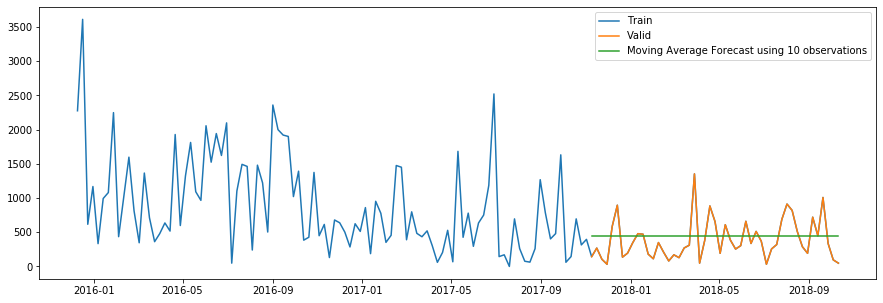

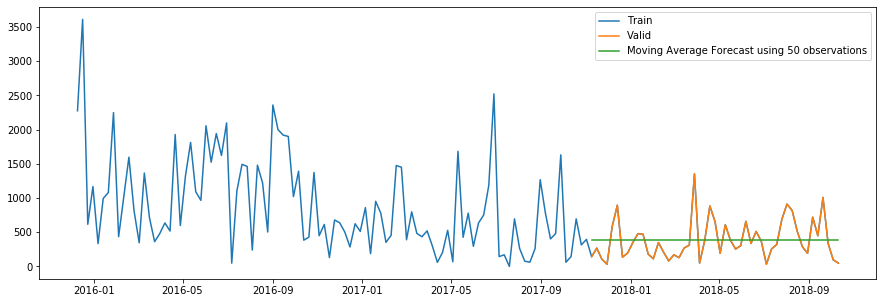

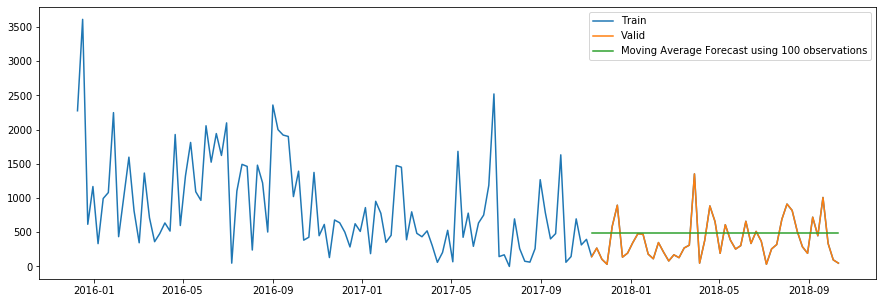

In [147]:
# rolling mean for last 10, 50, 100 

y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast_10'] = Train.rolling(10).mean().iloc[-1] # average of last 10 observations. 
plt.figure(figsize=(15,5)) 
plt.plot(Train, label='Train') 
plt.plot(valid, label='Valid') 
plt.plot(pd.Series(y_hat_avg['moving_avg_forecast_10'], valid.index), label='Moving Average Forecast using 10 observations') 
plt.legend(loc='best') 
plt.show() 

y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast_50'] = Train.rolling(50).mean().iloc[-1] # average of last 20 observations. 
plt.figure(figsize=(15,5)) 
plt.plot(Train, label='Train') 
plt.plot(valid, label='Valid') 
plt.plot(pd.Series(y_hat_avg['moving_avg_forecast_50'], valid.index), label='Moving Average Forecast using 50 observations') 
plt.legend(loc='best') 
plt.show() 

y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast_100'] = Train.rolling(100).mean().iloc[-1] # average of last 50 observations. 
plt.figure(figsize=(15,5)) 
plt.plot(Train, label='Train') 
plt.plot(valid, label='Valid') 
plt.plot(pd.Series(y_hat_avg['moving_avg_forecast_100'], valid.index), label='Moving Average Forecast using 100 observations') 
plt.legend(loc='best') 
plt.show()

In [92]:
mape_ma = mape_by_month(valid, [y_hat_avg.moving_avg_forecast for i in range(0, len(valid))])
print(mape_ma)   

97.91595751273476


## ExponentialSmoothing:

In [110]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt 

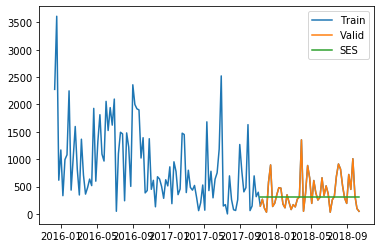

In [226]:
y_hat_avg = valid.copy() 
fit2 = SimpleExpSmoothing(np.asarray(Train)).fit(smoothing_level=0.3,optimized=False) 
y_hat_avg['SES'] = fit2.forecast(len(valid))

#plt.figure(figsize=(16,8)) 
plt.plot(Train, label='Train') 
plt.plot(valid, label='Valid') 
plt.plot(pd.Series(y_hat_avg['SES'], valid.index), label='SES') 
plt.legend(loc='best') 
plt.show()

In [227]:
mape_by_month(valid, y_hat_avg.SES)

64.77125599613966

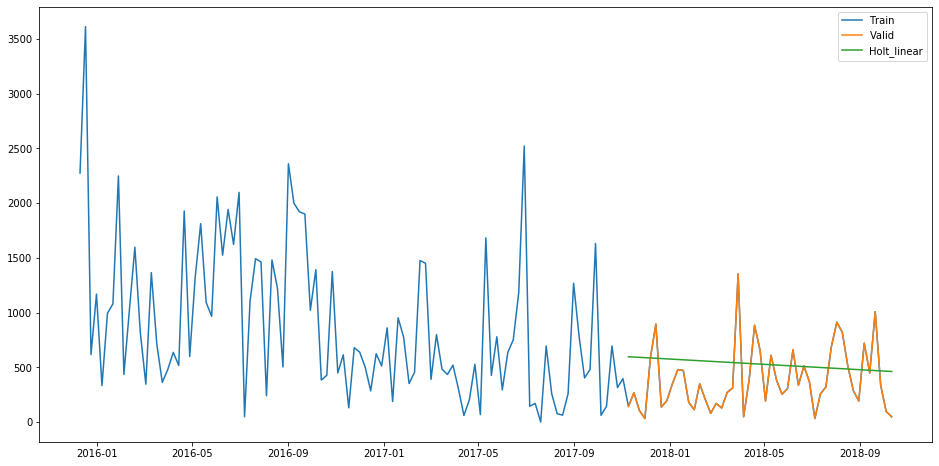

In [115]:
y_hat_avg = valid.copy() 
fit1 = Holt(np.asarray(Train)).fit(smoothing_level = 0.01, smoothing_slope = 0.01) 
y_hat_avg['Holt_linear'] = fit1.forecast(len(valid)) 
plt.figure(figsize=(16,8)) 
plt.plot(Train, label='Train') 
plt.plot(valid, label='Valid') 
plt.plot(pd.Series(y_hat_avg['Holt_linear'], valid.index), label='Holt_linear') 
plt.legend(loc='best') 
plt.show()

In [116]:
mape_by_month(valid, y_hat_avg.Holt_linear)

111.25186710125404

#### search parameters for Holt_Winter:

In [189]:
mape_pred = 150
y_hat_avg = valid.copy() 
for alpha in np.arange(0, .2, .05):
    for beta in np.arange(0, .2, .05):
        for gamma in np.arange(.6, .8, .05):
            fit1 = ExponentialSmoothing(np.asarray(Train) ,seasonal_periods=52, trend='add', seasonal='add',)
            fit1 = fit1.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
            potential_pred = fit1.forecast(len(valid)) 
            mape_potential_pred = mape_by_month(valid, potential_pred)
            if mape_potential_pred < mape_pred:
                mape_pred = mape_potential_pred
                param = [alpha, beta, gamma]
                
print(param, mape_pred)

[0.05, 0.05, 0.7500000000000001] 91.77515718253039


In [242]:
fit1 = ExponentialSmoothing(np.asarray(Train), seasonal_periods=52, trend='add', seasonal='add')
fit1 = fit1.fit(smoothing_level=param[0], smoothing_slope=param[1], smoothing_seasonal=param[2])
pred = fit1.forecast(len(valid)) 
mape_pred = mape_by_month(valid, pred)
mape_pred

66832.49886201636

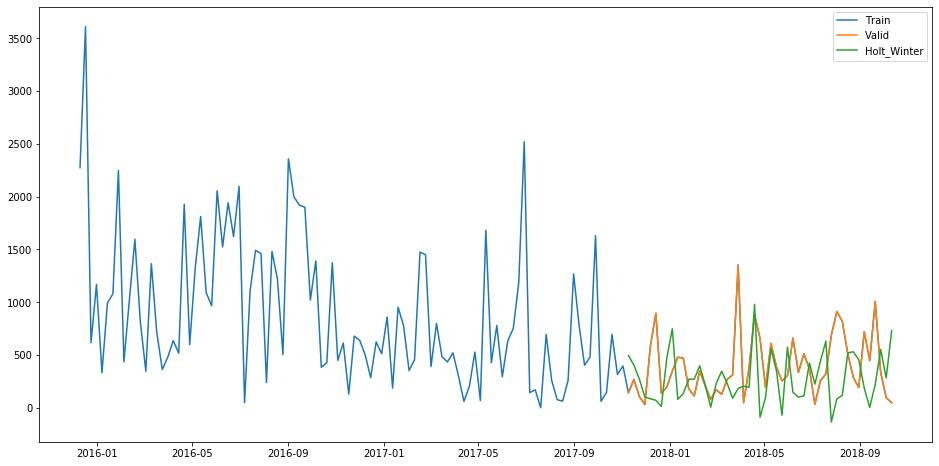

In [196]:
y_hat_avg['Holt_Winter'] = pred
            
plt.figure(figsize=(16,8)) 
plt.plot( Train, label='Train') 
plt.plot(valid, label='Valid') 
plt.plot(pd.Series(y_hat_avg['Holt_Winter'], valid.index), label='Holt_Winter') 
plt.legend(loc='best') 
plt.show()

## ARIMA:

#### MAKING THE TIME SERIES STATIONARY

#### use 1 SCU for prediction:

### There are two major factors that make a time series non-stationary:
#### • Trend: non-constant mean
#### • Seasonality: Variation at specific time-frames

### Trend:
#### Transformation log(log, sq-rt, cube root etc):

In [121]:
Train = Train + 0.1
valid = valid + 0.1

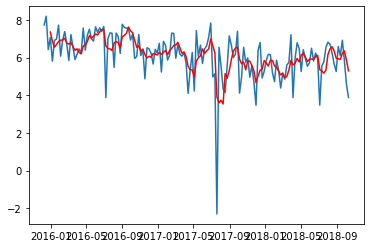

In [122]:
Train_log = np.log(Train) 
valid_log = np.log(valid)
moving_avg = Train_log.rolling(4).mean()
plt.plot(Train_log) 
plt.plot(moving_avg, color = 'red') 
plt.show()

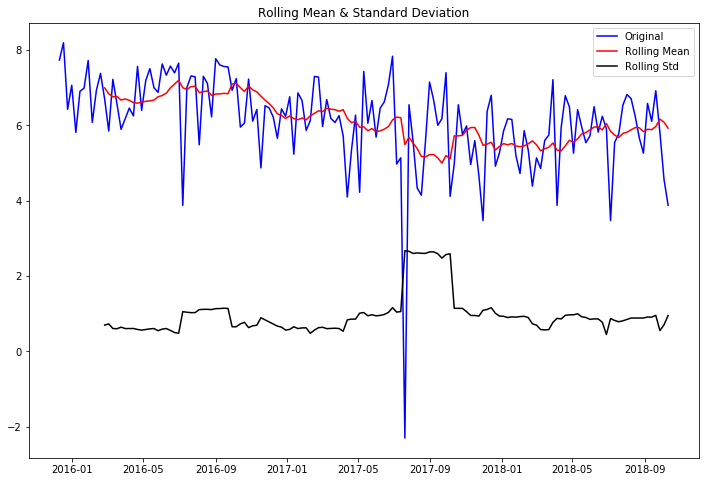

Results of Dickey-Fuller Test:
p-value = 0.5175. The series is likely non-stationary.
Test Statistic                  -1.532353
p-value                          0.517450
#Lags Used                      13.000000
Number of Observations Used    135.000000
Critical Value (1%)             -3.479743
Critical Value (5%)             -2.883198
Critical Value (10%)            -2.578320
dtype: float64


In [117]:
test_stationarity(Train_log)

### Seasonality (along with Trend):
#### • Differencing: by taking difference using time lag
#### • Decomposition: model both trend and seasonality, then remove them 

#### Differencing:

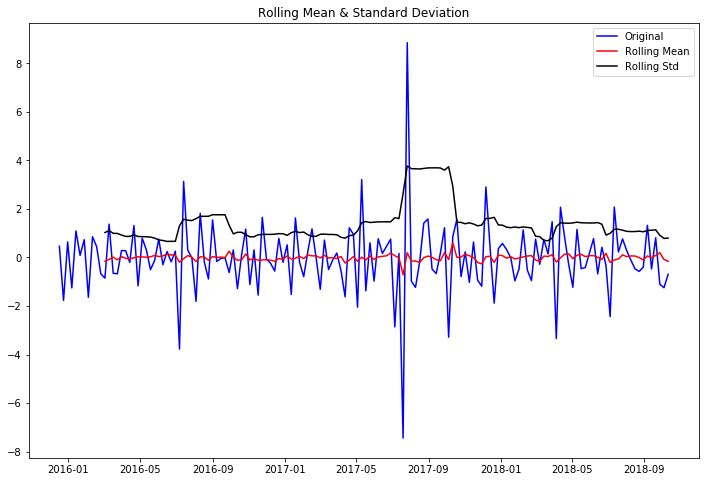

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -5.852605e+00
p-value                        3.560264e-07
#Lags Used                     1.700000e+01
Number of Observations Used    1.300000e+02
Critical Value (1%)           -3.481682e+00
Critical Value (5%)           -2.884042e+00
Critical Value (10%)          -2.578770e+00
dtype: float64


In [126]:
train_log_diff = Train_log - Train_log.shift(1) 
test_stationarity(train_log_diff.dropna())

#### Decomposition:

In [119]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(Train_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residuals = decomposition.resid

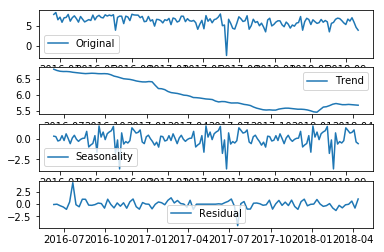

In [120]:
plt.subplot(411)
plt.plot(Train_log, label = 'Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residuals, label = 'Residual')
plt.legend(loc='best')

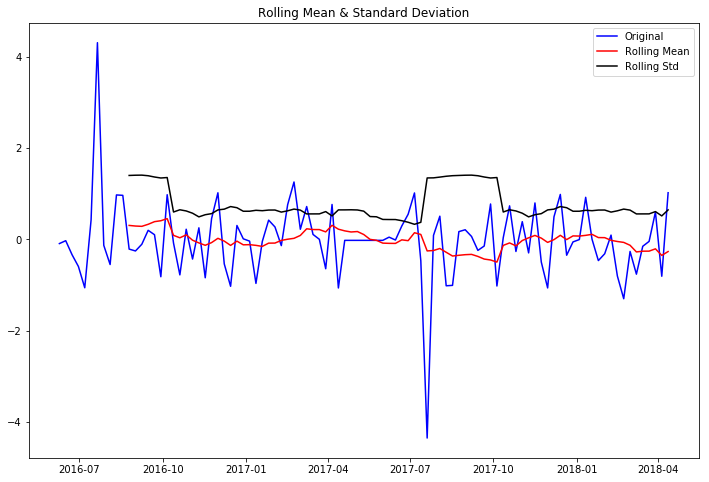

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -8.678605e+00
p-value                        4.347392e-14
#Lags Used                     1.000000e+00
Number of Observations Used    9.500000e+01
Critical Value (1%)           -3.501137e+00
Critical Value (5%)           -2.892480e+00
Critical Value (10%)          -2.583275e+00
dtype: float64


In [121]:
test_stationarity(residuals.dropna())

### For our model use 'Differencing':

## Forecasting:

In [123]:
# select 'Differencing':data_pred2:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

In [124]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))

<Figure size 864x576 with 0 Axes>

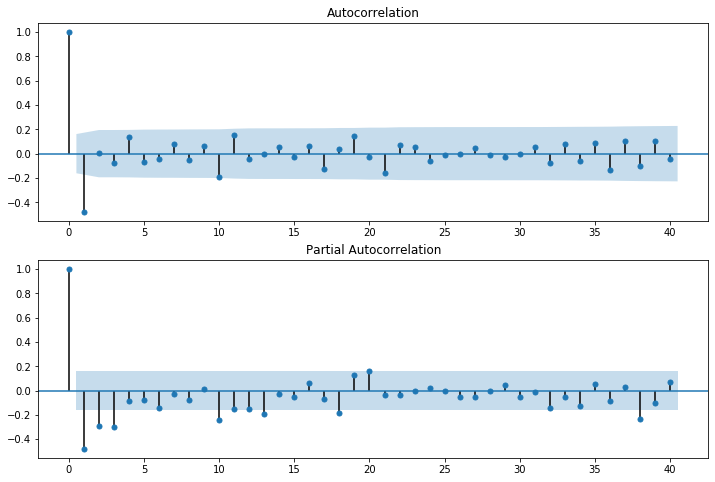

In [127]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_log_diff.dropna(), lags=40, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_log_diff.dropna(), lags=40, ax=ax2)

### p, q = 1

### Building models:

#### Eval func:

### AR:

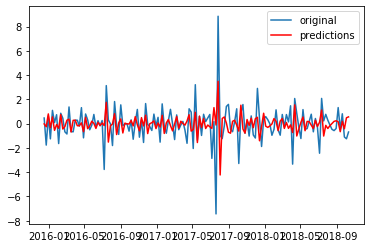

In [128]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(Train_log, order=(1, 1, 0))  # here the q value is zero since it is just the AR model 
results_AR = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_AR.fittedvalues, color='red', label='predictions') 
plt.legend(loc='best') 
plt.show()

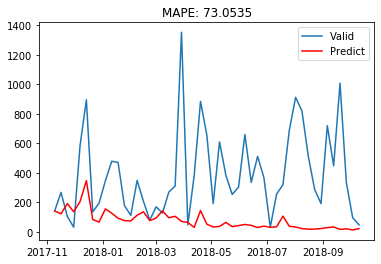

In [129]:
AR_predict=results_AR.predict(start="2017-11-09", end="2018-10-11") 
AR_predict=AR_predict.cumsum().shift().fillna(0) 
AR_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid)[0], index = valid.index) 
AR_predict1=AR_predict1.add(AR_predict,fill_value=0) 
AR_predict = np.exp(AR_predict1)
plt.plot(valid, label = "Valid") 
plt.plot(AR_predict, color = 'red', label = "Predict") 
plt.legend(loc= 'best') 
plt.title('MAPE: %.4f'% mape_by_month(valid, AR_predict)) 
plt.show()

### MA:

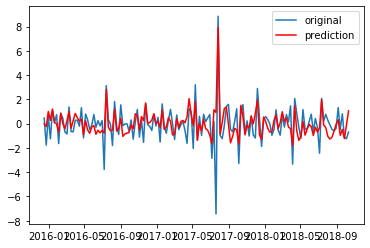

In [135]:
model = ARIMA(Train_log, order=(0, 1, 1))  # here the p value is zero since it is just the MA model 
results_MA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_MA.fittedvalues, color='red', label='prediction') 
plt.legend(loc='best') 
plt.show()

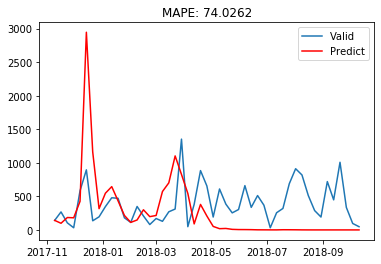

In [139]:
MA_predict=results_MA.predict(start="2017-11-09", end="2018-10-11") 
MA_predict=MA_predict.cumsum().shift().fillna(0) 
MA_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid)[0], index = valid.index) 
MA_predict1=MA_predict1.add(MA_predict,fill_value=0) 
MA_predict = np.exp(MA_predict1)
plt.plot(valid, label = "Valid") 
plt.plot(MA_predict, color = 'red', label = "Predict") 
plt.legend(loc= 'best') 
plt.title('MAPE: %.4f'% mape_by_month(valid, MA_predict))
plt.show()

### AR+I+MA = ARIMA model:

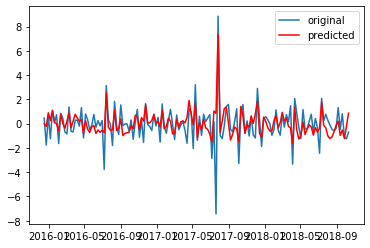

In [143]:
model = ARIMA(Train_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(),  label='original') 
plt.plot(results_ARIMA.fittedvalues, color='red', label='predicted') 
plt.legend(loc='best') 
plt.show()

In [144]:
def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set)[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)

    plt.plot(given_set, label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('MAPE: %.4f'% mape_by_month(given_set, predict)) 
    plt.show()
    
def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)
 
    plt.plot(given_set, label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('MAPE: %.4f'% mape_by_month(given_set, predict)) 
    plt.show()

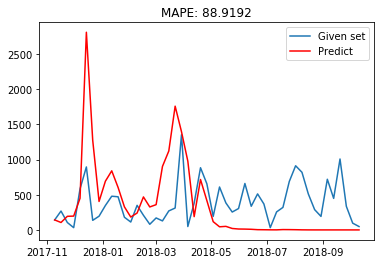

In [145]:
ARIMA_predict_diff=results_ARIMA.predict(start="2017-11-09", end="2018-10-11") 
check_prediction_diff(ARIMA_predict_diff, valid)

## SARIMAX:

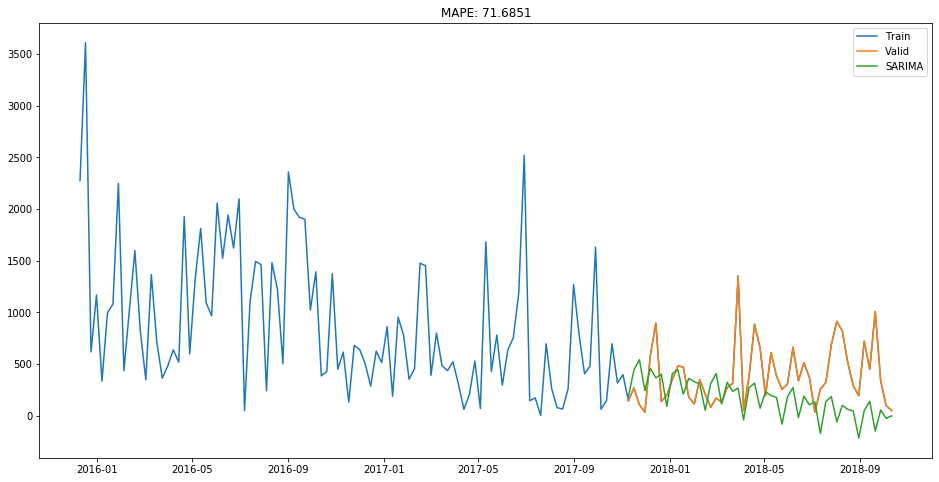

In [263]:
import statsmodels.api as sm
y_hat_avg = valid.copy() 
fit1 = sm.tsa.statespace.SARIMAX(Train, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit() 
y_hat_avg['SARIMA'] = fit1.predict(start="2017-11-09", end="2018-10-11", dynamic=True) 

plt.figure(figsize=(16,8)) 
plt.plot( Train, label='Train') 
plt.plot(valid, label='Valid') 
plt.plot(y_hat_avg['SARIMA'], label='SARIMA') 
plt.title('MAPE: %.4f'% mape_by_month(valid, y_hat_avg['SARIMA']))
plt.legend(loc='best') 
plt.show()

### Auto_ARIMA:

In [223]:
period = 49
model = auto_arima(Train,
                      start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

results_AA = model.fit(valid)

future_forecast = model.predict(n_periods = period, return_conf_int=False)

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=2150.429, BIC=2165.029, Fit time=1.455 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=2200.103, BIC=2205.943, Fit time=0.017 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=2170.107, BIC=2181.787, Fit time=0.488 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=2149.607, BIC=2161.287, Fit time=1.163 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=2149.638, BIC=2164.238, Fit time=1.628 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=2198.281, BIC=2207.041, Fit time=0.224 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 2, 12); AIC=2149.717, BIC=2164.317, Fit time=3.413 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 1, 2, 12); AIC=2151.569, BIC=2169.089, Fit time=3.638 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 1, 12); AIC=2150.755, BIC=2159.515, Fit time=0.457 seconds
Fit ARIMA: order=(0, 0, 2) s

In [210]:
mape_by_month(valid, future_forecast)

92.57509106139776

In [188]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  190
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -1456.467
Date:                            Fri, 04 Oct 2019   AIC                           2922.935
Time:                                    17:33:58   BIC                           2938.844
Sample:                                         0   HQIC                          2929.386
                                            - 190                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -10.1559     26.012     -0.390      0.696     -61.139      40.827
ma.L1          0.2839      0.052      5.488      0.000       0.183       0.385
ar.S.L12      -0.1950      0.110     -1.772      0.076      -0.411       0.021
ma.S.L12      -0.8827      0.063    -14.120      0.000      -1.005      -0.760
sigma2      6.799e+05   5.08e+04     13.378      0.000     5.8e+05     7.8e+05
===================================================================================
Ljung-Box (Q):                       29.99   Jarque-Bera (JB):               440.75
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             2.07
Prob(H) (two-sided):                  0.59   Kurtosis:                         9.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### TBATS:

In [218]:
from tbats import TBATS, BATS

estimator = TBATS(seasonal_periods = [52.18])

model = estimator.fit(Train)
y_forecast = model.forecast(steps=49)

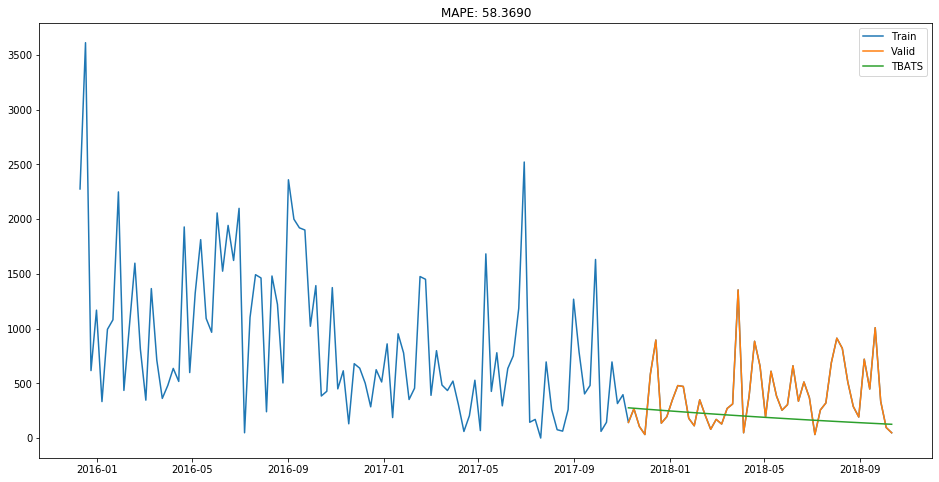

In [261]:
plt.figure(figsize=(16,8)) 
plt.plot( Train, label='Train') 
plt.plot(valid, label='Valid') 
plt.plot(pd.Series(y_forecast, valid.index), label='TBATS') 
plt.legend(loc='best') 
plt.title('MAPE: %.4f'%(mape_by_month(valid, y_forecast)))
plt.show()

### Prophet

In [245]:
from fbprophet import Prophet
import logging

logging.getLogger().setLevel(logging.ERROR)

In [250]:
prediction_size = 49

Train_Prophet = Train.reset_index()
valid_Prophet = valid.reset_index()
Train_Prophet.columns = ['ds', 'y']
valid_Prophet.columns = ['ds', 'y']

In [251]:
m = Prophet()
m.fit(Train_Prophet)

In [252]:
future = m.make_future_dataframe(periods=prediction_size)
forecast = m.predict(future)

In [253]:
forecast = m.predict(future)

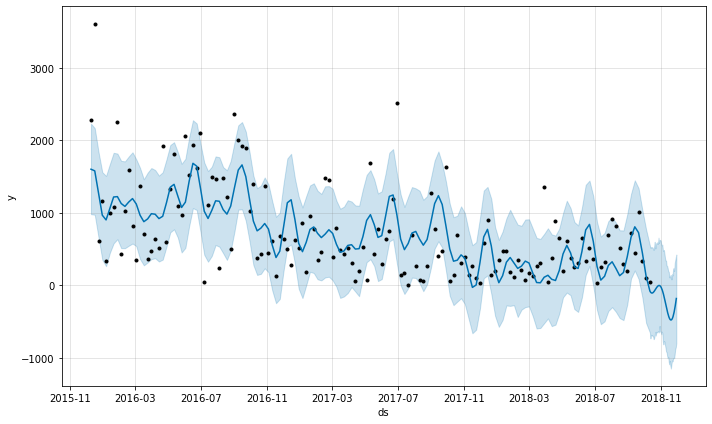

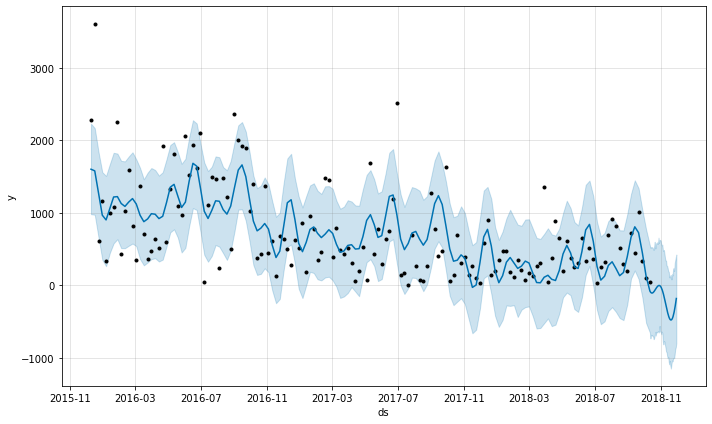

In [254]:
m.plot(forecast)

In [257]:
forecast.set_index('ds', inplace = True)

In [259]:
mape_by_month(valid, forecast['yhat'])

41.52146872627787

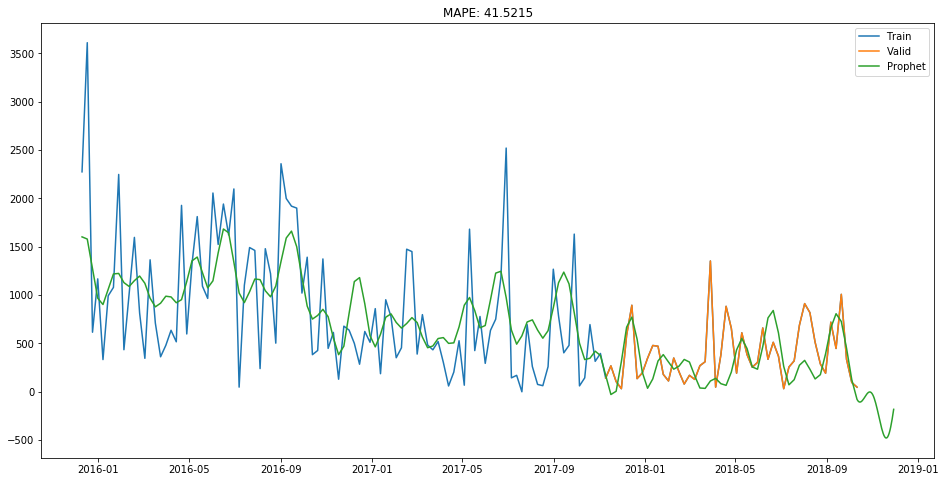

In [260]:
plt.figure(figsize=(16,8)) 
plt.plot( Train, label='Train') 
plt.plot(valid, label='Valid') 
plt.plot(forecast['yhat'], label='Prophet') 
plt.legend(loc='best') 
plt.title('MAPE: %.4f'%(mape_by_month(valid, forecast['yhat'])))
plt.show()